## Méthodes d'optimisation stochastique

## I. Minimisation stochastique d'une fonction déterministe


On s'intéresse au problème $\min f(x) =\max_{i=1\dots m}|a_i^Tx-b_i | = \max_{i=1\dots m} |(Ax-b)_i|.$ 

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne nulle et d'écart type identité.

**Question 1 :** Constuire $A$ et $b$. Proposer le calcul d'un sous-gradient en $x$ de $f$. On pourra utiliser la fonction findmax de Julia. 


In [1]:
?findmax

search: findmax findmax! findmin findmin!



In [2]:
using Random
using Statistics
# Construction des données A  et b
# Insérer votre code

m = 100;
n = 20;
A = randn(m,n);
b = randn(m,1);
x = randn(n,1)
# Fin insérer code

# Fonction calculant un sous-gradient en x de f
function subgrad(A,b,x) 
    # Insérer votre code
    fx = A*x - b;
    (max,ind) = findmax(abs.(fx));
    i = ind[1]
    return (sign(fx[i]))*A[i,:];
    # Fin insérer code
end

subgrad (generic function with 1 method)

**Question 2 :** Ce problème peut se reformuler comme un problème de programmation linéaire : $$(\mathcal{P}_{lp})\quad \left\{ \begin{array}{c} \min_{(x,R)\in \mathbb{R}^n\times \mathbb{R}} h(x,R)=R\\
s.c. \quad-R*e\leq A*x-b\leq R*e\end{array}\right.$$ avec $e=[1,\cdots,1]^T\in \mathbb{R}^m$. Résoudre le problème $(\mathcal{P}_{lp})$ en utilisant le solveur "GLPK" de la librairie JuMP. Plus d'informations sont disponibles ici :  http://www.juliaopt.org/JuMP.jl/latest/quickstart/

In [3]:
using JuMP
using GLPK

# Définition du modèle
# Insérer votre code

model = Model(GLPK.Optimizer)
# Fin insérer code

# Définition des variables d'optimisation
# Insérer votre code
@variable(model, x[1:n]);
@variable(model, R);


# Fin insérer code

# Définition de la fonctionnelle à minimiser
#Insérer votre code

@objective(model, Min, R);

# Fin insérer code

# Définition des contraintes
# Insérer votre code

@constraint(model, c1[i=1:m], R >= (sum(A[i,j]*x[j] for j in 1:n) - b[i]));
@constraint(model, c2[i=1:m], -R <= (sum(A[i,j]*x[j] for j in 1:n) - b[i]));

#for i=1:m
#    @constraint(model, sum(A[i,j]*x[j] for j in 1:n) - b[i] - R <= 0);
#    @constraint(model, sum(A[i,j]*x[j] for j in 1:n) - b[i] + R >= 0);
#end
# Fin insérer code
        
# Résolution        
# Insérer votre code

optimize!(model);


# Fin insérer code
        
# Résultats à optimalité                
# Insérer votre code
xstar = value.(x); 
Rstar = value.(R);

# Fin insérer code
println("The function value at the solution is: ",Rstar, " or ",findmax(abs.(A*xstar-b))[1])

The function value at the solution is: 1.7607085438717973 or 1.7607085438717982


**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Dans un premier temps vous utiliserez un sous-gradient exact (Question 1), puis vous introduirez un bruit artificiel qui suit une distribution normale de moyenne nulle et d'écart-type $3 e-1$.

**Question 4 :** Vous afficherez les courbes de convergence de $f_{best}^k-f_{star}$, avec $f_{star}$ obtenue à la Question 1. Donnez la valeur minimale de $f_{best}^k-f_{star}$.

La meilleur valeur de f_best-R_star est: 
Sans bruit: 0.0901204508968656
Bruité: 0.0904336073441272


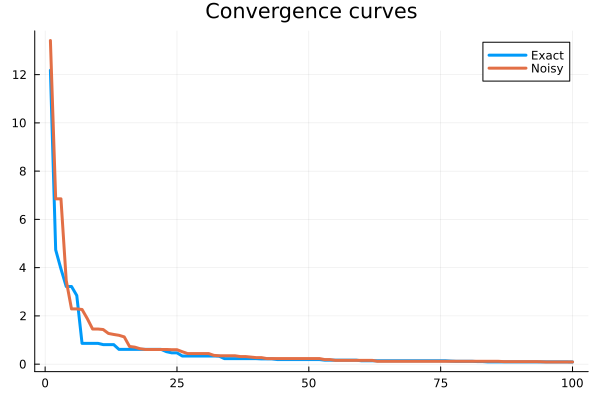

In [97]:

using Plots

#Initialisation
x = zeros(n,1);
i = 0;
fbest =1e10; # $f_{best}^0$: cas du sous-gradient exact
fbestp=1e10; # $f_{best}^0$: cas du sous-gradient bruité
histo =[];# Suite des itérés f_{best}^k-f_{star} pour le cas du sous-gradient exact
histop=[];# Suite des itérés f_{best}^k-f_{star}, pour le cas du sous-gradient bruité

#Niveau de bruit
noise_lvl=.3;

# Resolution 
# Insérer votre code
itermax = 100
xp = x
xp_b = x
while i < itermax
    i = i + 1
    ak = 1/(i)
    xp = xp - ak*subgrad(A,b,xp)
    fxp = findmax(abs.(A*xp-b))[1]   
    if (fxp < fbest) 
        fbest = fxp
    end
    xp_b = xp_b - ak*(subgrad(A,b,xp_b) + noise_lvl*randn(n,1));
    fxpb = findmax(abs.(A*xp_b-b))[1]   
    if (fxpb < fbestp) 
        fbestp = fxpb
    end
    append!(histo, fbest-Rstar)
    append!(histop, fbestp-Rstar)
end
# Fin insérer code

#Affichage des courbes de convergence
iter=1:100;
hf=[histo,histop];
print("La meilleur valeur de f_best-R_star est: ")
print('\n')
println("Sans bruit: " * string(histo[100]))
println("Bruité: " * string(histop[100]))
plot(iter,hf,title="Convergence curves",label=["Exact" "Noisy"],lw=3)

## II. Minimisation stochastique d'une fonction stochatique



On s'intéresse au problème
$$\min_x f(x) =\text{E} (\max_{i=1\dots m}|a_i^Tx-b_i |).$$

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne connue $\bar{A}$ et $\bar{b}$ (non nécesairement nulle) et d'écart type identité.

**Question 5 :** Proposer deux fonctions d'évaluation de la fonction $f$ et d'un sous-gradient de $f$ basées sur des échantillons de taille $M$.


In [8]:
# Evaluation de f
function fvals(Abar,bbar,noise,xs,M) 
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon

# Insérer votre code
    s = 0
    for i=1:M
        A = noise*randn(m,n) + Abar
        b = noise*randn(m,1) + bbar
        s += findmax(abs.(A*xs-b))[1]
    end
    return s/M
# Fin insérer code

end

# Evaluation d'un sous-gradient
function subgrads(Abar,bbar,noise,xs,M)
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon
    
# Insérer votre code

    s = zeros(n,1)
    for i = 1:M
        A = noise*randn(m,n) + Abar
        b = noise*randn(m,1) + bbar
        s = s + subgrad(A,b,xs)
    end
    return s/M
# Fin insérer code

end


subgrads (generic function with 1 method)

**Question 6 :** Comparer les courbes de convergence du problème déterministe $$ \min_x f(x) = \max_{i=1\dots m}|\text{E} (a_i)^Tx-\text{E} (b_i) |,$$ et du problème stochastique obtenu avec $M=10,100,1000$ échantillons. Donnez la valeur minimale de $f$.

La meilleur valeur de f_best est: 
Deterministe: 55.94108353253991
Stochastique: 33.902598498420836


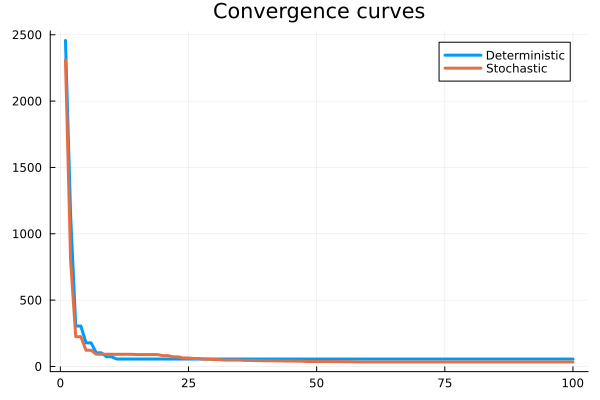

In [105]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

#x_0
xd = zeros(n,1); # problème déterministe
xs = xd; # problème stochastique

# Bruit et echantillon
M  = 100;
noise  = 4;

i = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
histod =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution déterministe
histos =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution stochastique

# Insérer votre code

itermax = 100
while i < itermax
    i = i + 1
    ak = 1/i
    #resolution deterministe
    xd = xd - ak*subgrad(Abar,bbar,xd);
    fxd = fvals(Abar,bbar,noise,xd,M)  
    if (fxd < fbestd) 
        fbestd = fxd
    end
    append!(histod, fbestd)
    #résolution stochastique
    xs = xs - ak*(subgrads(Abar,bbar,noise,xs,M))
    fxs = fvals(Abar,bbar,noise,xs,M) 
    if (fxs < fbests)
        fbests = fxs
    end
    append!(histos, fbests)
end

# Fin insérer code
#Affichage

iter=1:100;
hf=[histod,histos];
print("La meilleur valeur de f_best est: ")
print('\n')
println("Deterministe: " * string(histod[100]))
println("Stochastique: " * string(histos[100]))
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)

On remarque que la convergence de la méthode stochastique est proportionelle à la taille de l'enchantillon. Ainsi la méthode stochastique converge vers une meilleure valeur, pour un M grand, que la méthode déterministe.

**Question 7 :** Répéter les expériences et comparer les valeurs meilleurs valeurs de f obtenues ($f_{best}$) aprs un nombre fixé d'itérations. Donnez la valeur minimale de $f_{best}$

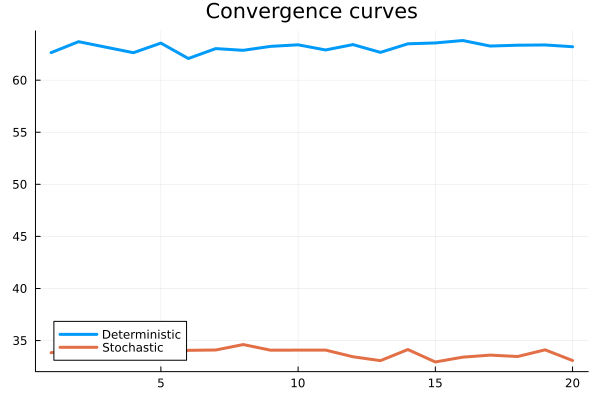

In [106]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

# x_0
xd = zeros(n,1); # résolution déterministe
xs = xd;  # résolution stochastique

# Bruit et echantillon
M  = 100;
noise  = 4;

#Nombre d'itérations
niter=100;

j = 0;


fbesttd=[]; # f_{best} pour chaque expériences dans le cas d'une résolution déterministe
fbestts=[]; # f_{best} pour chaque expériences dans le cas d'une résolution stochastique

for nexp=1:20
    # Répétition des expériences
    fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
    fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique    
    # Insérer votre code
    itermax = niter
    xd = zeros(n,1); 
    xs = xd;
    i=0
    while i < itermax
        i = i + 1
        ak = 1/(i)
        #resolution deterministe
        xd = xd - ak*subgrad(Abar,bbar,xd);
        fxd = fvals(Abar,bbar,noise,xd,M)   
        if (fxd < fbestd) 
            fbestd = fxd
        end
        #résolution stochastique
        xs = xs - ak*(subgrads(Abar,bbar,noise,xs,M))
        fxs = fvals(Abar,bbar,noise,xs,M) 
        if (fxs < fbests)
            fbests = fxs
        end
    end
    append!(fbesttd,fbestd)
    append!(fbestts,fbests)
# Fin insérer code
end

#Affichage

iter=1:20;
hf=[fbesttd,fbestts];

plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)

In [80]:
print("La meilleur valeur de f_best après 20 itérations est: ")
print('\n')
println("Deterministe: " * string(findmin(fbesttd)[1]))
println("Stochastique: " * string(findmin(fbestts)[1]))

La meilleur valeur de f_best après 20 itérations est: 
Deterministe: 53.714108987208625
Stochastique: 34.39123131222139


On remarque qu'il y a un gap entre la méthode stochastique et la méthode déterministe. Ainsi l'approximation faite à la question 6 ne permet pas d'approcher rellement le minimum.